# Influenza transmission model (SLIR)
Version: 30 May 2024  
Run in python 3.9.12

Projections of the impact of transmission-reducing pediatric influenza vaccine in South Africa using high resolution immunologic and infection data  
Medxiv: https://doi.org/10.1101/2025.04.04.25325228 

Jackie Kleynhans 1,2, Cécile Viboud 3, Molly Sauter 3, Stefano Tempia 1,2, Nicole Wolter 1 4, Jocelyn Moyes1, Anne von Gottberg 1,4, Lorens Maake 1, Alexandra Moerdyk 1, Cheryl Cohen 1,2, Kaiyuan Sun 3

1 Centre for Respiratory Diseases and Meningitis, National Institute for Communicable Diseases of the National Health Laboratory Service, Johannesburg, South Africa; 

2 School of Public Health, Faculty of Health Sciences, University of the Witwatersrand, Johannesburg, South Africa; 

3 Division of International Epidemiology and Population Studies, Fogarty International Center, National Institutes of Health, Bethesda, Maryland, United States of America;

4 School of Pathology, Faculty of Health Sciences, University of the Witwatersrand, Johannesburg, South Africa.

Corresponding authors: Jackie Kleynhans jackiel@nicd.ac.za and Kaiyuan Sun kaiyuan.sun@nih.gov 


### Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import datetime
import pickle
import seaborn as sns
import re
import warnings
import os
import time
from typing import Literal
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Import parameters

In [ ]:
with open("Influenza model input parameters.pkl", 'rb') as file:
    # Load the dictionary from the file
    flu_model_param = pickle.load(file)

# Retrieve individual dictionaries/arrays
flu_weekly_ar_type_year_klerksdorp = flu_model_param['flu_weekly_ar_type_year_klerksdorp']
flu_weekly_ar_type_year_agincourt = flu_model_param['flu_weekly_ar_type_year_agincourt']
flu_cum_ar_type_year_klerksdorp = flu_model_param['flu_cum_ar_type_year_klerksdorp']
flu_cum_ar_type_year_agincourt = flu_model_param['flu_cum_ar_type_year_agincourt']
flu_year_draw_type_titre_klerksdorp = flu_model_param['flu_year_draw_type_titre_klerksdorp']
flu_year_draw_type_titre_agincourt = flu_model_param['flu_year_draw_type_titre_agincourt']
flu_type_alpha = flu_model_param['flu_type_alpha']
flu_type_alpha_nohai = flu_model_param['flu_type_alpha_nohai']
flu_type_beta = flu_model_param['flu_type_beta']
flu_type_beta_nohai = flu_model_param['flu_type_beta_nohai']
flu_type_mu = flu_model_param['flu_type_mu']
flu_type_mu_nohai = flu_model_param['flu_type_mu_nohai']
flu_type_sigma = flu_model_param['flu_type_sigma']
flu_type_sigma_nohai = flu_model_param['flu_type_sigma_nohai']
phirst_cm_klerksdorp = flu_model_param['phirst_cm_klerksdorp']
phirst_cm_agincourt = flu_model_param['phirst_cm_agincourt']
cm_polmd_sa = flu_model_param['cm_polmd_sa']
cm_polmd_uk = flu_model_param['cm_polmd_uk']
phirst_pop_klerksdorp = flu_model_param['phirst_pop_klerksdorp']
phirst_pop_agincourt = flu_model_param['phirst_pop_agincourt']
pop_uk = flu_model_param['pop_uk']
pop_sa = flu_model_param['pop_sa']

In [3]:
# Fitted parameters by site and year
param_site_year = {"klerk_2016":    [0.000031, 0.474430, 0.191071, 0.116436, 0.061167, 0.004514, 
                                    0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                                    0.000063, 0.157064, 0.053685, 0.064171, 0.033553, 0.001236, 
                                    0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                                    0.445793, 4.998893, 1.242199], #last update 31 May 2024
                    "klerk_2017" :  [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                                    0.000003, 0.200895, 0.017101, 0.038078, 0.000357, 0.000100, 
                                    0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                                    0.000003, 0.144756, 0.036425, 0.024829, 0.012626, 0.002823, 
                                    0.877411, 1.482922, 3.151570], #last update 31 May 2024
                    "klerk_2018" :  [0.000002, 0.041441, 0.187000, 0.062507, 0.075532, 0.000120, 
                                    0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                                    0.000009, 0.361485, 0.062446, 0.050232, 0.033030, 0.002940, 
                                    0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 
                                    0.288481, 2.298709, 3.314444], #last update 31 May 2024
                    "aginc_2016":   [0.000000, 0.309979, 0.083090, 0.089055, 0.036227, 0.013700, 
                                    0.000003, 0.421363, 0.045073, 0.022884, 0.010814, 0.001121, 
                                    0.000002, 0.321272, 0.027360, 0.038855, 0.013234, 0.001981, 
                                    0.000000, 0.001134, 0.001005, 0.001047, 0.001132, 0.001171, 
                                    0.546331, 3.996261, 0.209863], #last update 30 May 2024
                    "aginc_2017":   [0.000000, 0.001358, 0.001491, 0.001799, 0.001067, 0.001916, 
                                    0.000002, 0.037473, 0.052802, 0.048795, 0.025635, 0.001118, 
                                    0.000000, 0.001720, 0.002128, 0.001090, 0.001013, 0.001193, 
                                    0.000003, 0.221001, 0.025211, 0.029641, 0.021425, 0.001006, 
                                    0.432913, 3.096754, 0.308210], #last update 10 April 2024
                    "aginc_2018":   [0.000005, 0.244955, 0.054627, 0.063912, 0.016453, 0.001178, 
                                    0.000000, 0.277000, 0.043278, 0.012906, 0.007805, 0.001023, 
                                    0.000005, 0.252129, 0.043350, 0.026392, 0.030375, 0.001077, 
                                    0.000000, 0.001062, 0.001002, 0.001004, 0.001330, 0.001071, 
                                    0.443215, 0.175007, 1.967916]    #last update 10 April 2024            
                    }
# HAI values by site and year
hai_site_year = {"klerk_2016":      {'A(H1N1)': flu_year_draw_type_titre_klerksdorp[2016][1]['A(H1N1)'],
                                    'A(H3N2)': flu_year_draw_type_titre_klerksdorp[2016][1]['A(H3N2)'],
                                    'B(Victoria)': flu_year_draw_type_titre_klerksdorp[2016][1]['B(Victoria)'],
                                    'B(Yamagata)': flu_year_draw_type_titre_klerksdorp[2016][1]['B(Yamagata)']},
                    "klerk_2017" :  {'A(H1N1)': flu_year_draw_type_titre_klerksdorp[2017][2]['A(H1N1)'],
                                    'A(H3N2)': flu_year_draw_type_titre_klerksdorp[2017][2]['A(H3N2)'],
                                    'B(Victoria)': flu_year_draw_type_titre_klerksdorp[2017][2]['B(Victoria)'],
                                    'B(Yamagata)': flu_year_draw_type_titre_klerksdorp[2017][2]['B(Yamagata)']},
                    "klerk_2018" :  {'A(H1N1)': flu_year_draw_type_titre_klerksdorp[2018][2]['A(H1N1)'],
                                    'A(H3N2)': flu_year_draw_type_titre_klerksdorp[2018][2]['A(H3N2)'],
                                    'B(Victoria)': flu_year_draw_type_titre_klerksdorp[2018][2]['B(Victoria)'],
                                    'B(Yamagata)': flu_year_draw_type_titre_klerksdorp[2018][2]['B(Yamagata)']},
                    "aginc_2016":   {'A(H1N1)': flu_year_draw_type_titre_agincourt[2016][1]['A(H1N1)'],
                                    'A(H3N2)': flu_year_draw_type_titre_agincourt[2016][1]['A(H3N2)'],
                                    'B(Victoria)': flu_year_draw_type_titre_agincourt[2016][1]['B(Victoria)'],
                                    'B(Yamagata)': flu_year_draw_type_titre_agincourt[2016][1]['B(Yamagata)']},
                    "aginc_2017":  {'A(H1N1)': flu_year_draw_type_titre_agincourt[2017][2]['A(H1N1)'],
                                    'A(H3N2)': flu_year_draw_type_titre_agincourt[2017][2]['A(H3N2)'],
                                    'B(Victoria)': flu_year_draw_type_titre_agincourt[2017][2]['B(Victoria)'],
                                    'B(Yamagata)': flu_year_draw_type_titre_agincourt[2017][2]['B(Yamagata)']},
                    "aginc_2018":   {'A(H1N1)': flu_year_draw_type_titre_agincourt[2018][2]['A(H1N1)'],
                                    'A(H3N2)': flu_year_draw_type_titre_agincourt[2018][2]['A(H3N2)'],
                                    'B(Victoria)': flu_year_draw_type_titre_agincourt[2018][2]['B(Victoria)'],
                                    'B(Yamagata)': flu_year_draw_type_titre_agincourt[2018][2]['B(Yamagata)']}
                                    }

# Weekly attack rates by site and year
flu_type_fit_site_year = {"klerk_2016":      {'A(H1N1)': flu_weekly_ar_type_year_klerksdorp['A(H1N1)'][2016],
                                    'A(H3N2)': flu_weekly_ar_type_year_klerksdorp['A(H3N2)'][2016],
                                    'B(Victoria)': flu_weekly_ar_type_year_klerksdorp['B(Victoria)'][2016],
                                    'B(Yamagata)': flu_weekly_ar_type_year_klerksdorp['B(Yamagata)'][2016]},
                    "klerk_2017" :  {'A(H1N1)': flu_weekly_ar_type_year_klerksdorp['A(H1N1)'][2017],
                                    'A(H3N2)': flu_weekly_ar_type_year_klerksdorp['A(H3N2)'][2017],
                                    'B(Victoria)': flu_weekly_ar_type_year_klerksdorp['B(Victoria)'][2017],
                                    'B(Yamagata)': flu_weekly_ar_type_year_klerksdorp['B(Yamagata)'][2017]},
                    "klerk_2018" :  {'A(H1N1)': flu_weekly_ar_type_year_klerksdorp['A(H1N1)'][2018],
                                    'A(H3N2)': flu_weekly_ar_type_year_klerksdorp['A(H3N2)'][2018],
                                    'B(Victoria)': flu_weekly_ar_type_year_klerksdorp['B(Victoria)'][2018],
                                    'B(Yamagata)': flu_weekly_ar_type_year_klerksdorp['B(Yamagata)'][2018]},
                    "aginc_2016":      {'A(H1N1)': flu_weekly_ar_type_year_agincourt['A(H1N1)'][2016],
                                    'A(H3N2)': flu_weekly_ar_type_year_agincourt['A(H3N2)'][2016],
                                    'B(Victoria)': flu_weekly_ar_type_year_agincourt['B(Victoria)'][2016],
                                    'B(Yamagata)': flu_weekly_ar_type_year_agincourt['B(Yamagata)'][2016]},
                    "aginc_2017" :  {'A(H1N1)': flu_weekly_ar_type_year_agincourt['A(H1N1)'][2017],
                                    'A(H3N2)': flu_weekly_ar_type_year_agincourt['A(H3N2)'][2017],
                                    'B(Victoria)': flu_weekly_ar_type_year_agincourt['B(Victoria)'][2017],
                                    'B(Yamagata)': flu_weekly_ar_type_year_agincourt['B(Yamagata)'][2017]},
                    "aginc_2018" :  {'A(H1N1)': flu_weekly_ar_type_year_agincourt['A(H1N1)'][2018],
                                    'A(H3N2)': flu_weekly_ar_type_year_agincourt['A(H3N2)'][2018],
                                    'B(Victoria)': flu_weekly_ar_type_year_agincourt['B(Victoria)'][2018],
                                    'B(Yamagata)': flu_weekly_ar_type_year_agincourt['B(Yamagata)'][2018]}
                                    }

# Age-based attack rates by site and year
flu_type_ar_site_year = {"klerk_2016":      {'A(H1N1)': flu_cum_ar_type_year_klerksdorp['A(H1N1)pdm09'][2016],
                                    'A(H3N2)': flu_cum_ar_type_year_klerksdorp['A(H3N2)'][2016],
                                    'B(Victoria)': flu_cum_ar_type_year_klerksdorp['B(Victoria)'][2016],
                                    'B(Yamagata)': flu_cum_ar_type_year_klerksdorp['B(Yamagata)'][2016]},
                    "klerk_2017" :  {'A(H1N1)': flu_cum_ar_type_year_klerksdorp['A(H1N1)pdm09'][2017],
                                    'A(H3N2)': flu_cum_ar_type_year_klerksdorp['A(H3N2)'][2017],
                                    'B(Victoria)': flu_cum_ar_type_year_klerksdorp['B(Victoria)'][2017],
                                    'B(Yamagata)': flu_cum_ar_type_year_klerksdorp['B(Yamagata)'][2017]},
                    "klerk_2018" :  {'A(H1N1)': flu_cum_ar_type_year_klerksdorp['A(H1N1)pdm09'][2018],
                                    'A(H3N2)': flu_cum_ar_type_year_klerksdorp['A(H3N2)'][2018],
                                    'B(Victoria)': flu_cum_ar_type_year_klerksdorp['B(Victoria)'][2018],
                                    'B(Yamagata)': flu_cum_ar_type_year_klerksdorp['B(Yamagata)'][2018]},
                    "aginc_2016":      {'A(H1N1)': flu_cum_ar_type_year_agincourt['A(H1N1)pdm09'][2016],
                                    'A(H3N2)': flu_cum_ar_type_year_agincourt['A(H3N2)'][2016],
                                    'B(Victoria)': flu_cum_ar_type_year_agincourt['B(Victoria)'][2016],
                                    'B(Yamagata)': flu_cum_ar_type_year_agincourt['B(Yamagata)'][2016]},
                    "aginc_2017" :  {'A(H1N1)': flu_cum_ar_type_year_agincourt['A(H1N1)pdm09'][2017],
                                    'A(H3N2)': flu_cum_ar_type_year_agincourt['A(H3N2)'][2017],
                                    'B(Victoria)': flu_cum_ar_type_year_agincourt['B(Victoria)'][2017],
                                    'B(Yamagata)': flu_cum_ar_type_year_agincourt['B(Yamagata)'][2017]},
                    "aginc_2018" :  {'A(H1N1)': flu_cum_ar_type_year_agincourt['A(H1N1)pdm09'][2018],
                                    'A(H3N2)': flu_cum_ar_type_year_agincourt['A(H3N2)'][2018],
                                    'B(Victoria)': flu_cum_ar_type_year_agincourt['B(Victoria)'][2018],
                                    'B(Yamagata)': flu_cum_ar_type_year_agincourt['B(Yamagata)'][2018]}
                                    }

#### Custom functions: Summary measures

In [4]:
def weekly_incidence (sir_output):
    Daily_cases = np.sum(sir_output[:, :, :, :, 2], axis=(0, 1, 2))
    Weekly_inc = [((sum(Daily_cases[i:i+7]) / model_pop_size(sir_output)) * 100) for i in range(0, len(Daily_cases[1:]), 7)]
    return Weekly_inc

def model_pop_size(sir_output):
    N_age = np.array((np.sum(sir_output[0,:,:,0,0]), np.sum(sir_output[1,:,:,0,0]), np.sum(sir_output[2,:,:,0,0]), 
                np.sum(sir_output[3,:,:,0,0]), np.sum(sir_output[4,:,:,0,0]), np.sum(sir_output[5,:,:,0,0]), 
                np.sum(sir_output[6,:,:,0,0])))
    N = np.sum(N_age)
    return N

def ar_age_overall (sir_output):
    AttrackRate_MD = [np.sum(sir_output[0, :, :, :, 2]) /
                np.sum(sir_output[0, :, :, 0, 0]),
                np.sum(sir_output[1, :, :, :, 2]) /
                np.sum(sir_output[1, :, :, 0, 0]),
                np.sum(sir_output[2, :, :, :, 2]) /
                np.sum(sir_output[2, :, :, 0, 0]),
                np.sum(sir_output[3, :, :, :, 2]) /
                np.sum(sir_output[3, :, :, 0, 0]),
                np.sum(sir_output[4, :, :, :, 2]) /
                np.sum(sir_output[4, :, :, 0, 0]),
                np.sum(sir_output[5, :, :, :, 2]) /
                np.sum(sir_output[5, :, :, 0, 0]),
                np.sum(sir_output[6, :, :, :, 2])/
                np.sum(sir_output[6, :, :, 0, 0])]
    AttrackRate100_MD = [round(i * 100, 2) for i in AttrackRate_MD]
    ARoverall_MD = round((np.sum(sir_output[:, :, :, :, 2]) / model_pop_size(sir_output)) * 100, 2)
    AttrackRate100_MD.append(ARoverall_MD)
    return AttrackRate100_MD

### MODEL

In [ ]:
 # SEIR MODEL
def SEIR_vac (vac_cov, ves, vei, ved, cm_mod, param0, pop, hai, flu_type_fit):
    pop = pop
    cm = cm_mod
    hai_titre = hai

    param = {
    'A(H1N1)': {'Ip':param0[0],
                'omega_2':param0[24],
                'omega_3':param0[25],
                'omega_4':param0[26],
                'gamma_1':param0[1],
                'gamma_2':param0[2],
                'gamma_3':param0[3],
                'gamma_4':param0[4],
                'gamma_5':param0[5]},
    'A(H3N2)': {'Ip': param0[6],
                'omega_2':param0[24],
                'omega_3':param0[25],
                'omega_4':param0[26],
                'gamma_1':param0[7],
                'gamma_2':param0[8],
                'gamma_3':param0[9],
                'gamma_4':param0[10],
                'gamma_5':param0[11]},
    'B(Victoria)': {'Ip': param0[12],
                'omega_2':param0[24],
                'omega_3':param0[25],
                'omega_4':param0[26],
                'gamma_1':param0[13],
                'gamma_2':param0[14],
                'gamma_3':param0[15],
                'gamma_4':param0[16],
                'gamma_5':param0[17]},
    'B(Yamagata)': {'Ip': param0[18],
                'omega_2':param0[24],
                'omega_3':param0[25],
                'omega_4':param0[26],
                'gamma_1':param0[19],
                'gamma_2':param0[20],
                'gamma_3':param0[21],
                'gamma_4':param0[22],
                'gamma_5':param0[23]}}
    
    #Dictionaries to store results
    sir_array_res = {}
    sir_array_sq = {}
    sir_array_sq_curve = {}
    sir_array_sq_ar = {}

    #Virusses to loop through
    virus_names = ('A(H1N1)', 'A(H3N2)', 'B(Victoria)', 'B(Yamagata)')
    
    for virus in virus_names:
    
        #Define levels (dimentions) of the model (array to store data)
        age_groups = ["<6 months", "6 months - 5 years", "6-12 years", "13-18 years", "19-44 years", "45-64 years","65+ years"]
        pre_season_titres = ["titre_" + titre for titre in ["<40", "40-<160","160+"]]
        vaccine_states = ["Unvaccinated", "Vaccinated"]
        T = list(range(1,(len(flu_type_fit[virus]+1)*7*1)))
        compartments = ["S", "E", "Inf", "I", "Rec", "R"]

        #Layers used for contact matrices
        contact_layers = ["Home", "School", "Work", "Other"]

        # Create sir_array 
        sir_array = np.empty(shape=(len(age_groups), len(pre_season_titres),
                                    len(vaccine_states), len(T), len(compartments)))

        #Specify parameters (all stored in arrays relative to position of age age_groups in pre_season_titres)

        #Proportion of infections detected
        p = 1

        #Proportion starting as suceptable
        Sp = np.array((1, 1, 1, 1, 1, 1, 1)) 

        #Proportion starting as exposed
        Ep = 0

        #Time unit
        dt = 1

        #Population size and structure
        N_aim = 10000000

        #Specify population via input parameters
        N_age_str = pop
        N_age = N_age_str * N_aim
        N = sum(N_age)

        #Pre-season titre prevelance
        Ptitre =  hai_titre[virus]

        #Weight of contact matrtix layers
        omega = np.array([1, param[virus]['omega_2'], param[virus]['omega_3'], param[virus]['omega_4']])

        #Vaccine coverage [VE taken as the same accross HAI titres]
        vCov_age = np.repeat(np.array((vac_cov))[:, np.newaxis], 3, axis=1)
        #Reduction of susceptibility
        VEs = np.repeat(np.array((ves))[:, np.newaxis], 3, axis=1)
        #Reduction of infectiousness (Ct value / viral load)
        VEi = np.repeat(np.array((vei))[:, np.newaxis], 3, axis=1)
        #Reduction of duration of infectious period
        VEd = np.repeat(np.array((ved))[:, np.newaxis], 3, axis=1)
        #Reduction of transmisibility (combination of both)
        VEt = np.array((1 - (1-VEi)*(1-VEd)))

        #Time in exposed
        sigma_u = flu_type_sigma[virus]
        sigma_v = sigma_u
        sigma = np.array((sigma_u, sigma_v))
        
        #Susceptibility 
        alpha_u = flu_type_alpha[virus]
        alpha_v = np.array((alpha_u*(1-VEs)))
        alpha = np.array((alpha_u, alpha_v))
               
        #Infectiousness 
        beta_u = flu_type_beta[virus]
        beta_v = np.array((beta_u*(1-VEi)))
        beta = np.array((beta_u, beta_v))
        
        #Recovery rate 
        mu_u = flu_type_mu[virus]
        mu_v = np.array((mu_u*(1-VEd)))
        mu = np.array((mu_u, mu_v))
  
        #Transmisibility
        #Fit a spline function to the original inserted parameters to generate a gamma value for each time point
        gamma = [param[virus]['gamma_1'], param[virus]['gamma_2'], param[virus]['gamma_3'], param[virus]['gamma_4'], 
                    param[virus]['gamma_5']]
        # Create an array of indices for the original gamma values
        x = np.arange(len(gamma))
        # Fit a cubic spline to the gamma values
        cs = CubicSpline(x, gamma)
        # Create an array of indices for the desired fit_len
        x_fit = np.linspace(0, len(gamma) - 1, len(T))
        # Extrapolate the gamma values using the spline function
        gamma_ts = cs(x_fit)
        
        #Populate initial values for S and I
        for k, titre in enumerate(pre_season_titres):
            for i, age_group in enumerate(age_groups):
                #Unvaccinated
                n_unvaccinated = round(N_age[i] * (1 - vCov_age[i][k]) * Ptitre[i][k])
                s_unvaccinated = round(n_unvaccinated * Sp[i])
                i_unvaccinated = round(n_unvaccinated * param[virus]['Ip'])
                e_unvaccinated = round(n_unvaccinated * Ep)
                sir_array[i, k, 0, 0, 0] = s_unvaccinated - i_unvaccinated - e_unvaccinated
                sir_array[i, k, 0, 0, 1] = e_unvaccinated
                sir_array[i, k, 0, 0, 2] = 0
                sir_array[i, k, 0, 0, 3] = i_unvaccinated
                sir_array[i, k, 0, 0, 4] = 0
                sir_array[i, k, 0, 0, 5] = round(n_unvaccinated - sir_array[i, k, 0, 0, 0] - sir_array[i, k, 0, 0, 1] - sir_array[i, k, 0, 0, 3])
                #Vaccinated
                n_vaccinated = round(N_age[i] * (vCov_age[i][k]) * Ptitre[i][k])
                s_vaccinated = round(n_vaccinated * Sp[i])
                i_vaccinated = round(n_vaccinated * param[virus]['Ip'])
                e_vaccinated = round(n_vaccinated * Ep)
                sir_array[i, k, 1, 0, 0] = s_vaccinated - i_vaccinated - e_vaccinated
                sir_array[i, k, 1, 0, 1] = e_vaccinated
                sir_array[i, k, 1, 0, 2] = 0
                sir_array[i, k, 1, 0, 3] = i_vaccinated
                sir_array[i, k, 1, 0, 4] = 0
                sir_array[i, k, 1, 0, 5] = round(n_vaccinated - sir_array[i, k, 1, 0, 0] - sir_array[i, k, 1, 0, 1] - sir_array[i, k, 1, 0, 3])

        #Store final population denominators
        #By age
        N_age = np.array((np.sum(sir_array[0,:,:,0,:]), np.sum(sir_array[1,:,:,0,:]), np.sum(sir_array[2,:,:,0,:]), 
                        np.sum(sir_array[3,:,:,0,:]), np.sum(sir_array[4,:,:,0,:]), np.sum(sir_array[5,:,:,0,:]), 
                        np.sum(sir_array[6,:,:,0,:])))
        N = np.sum(N_age)

        #By age and titre
        N_age_titre = np.empty((len(age_groups), len(pre_season_titres)), dtype=np.ndarray)
        for i in range(len(age_groups)):
            for j in range(len(pre_season_titres)):
                N_age_titre[i, j] = np.sum(sir_array[i, j, :, 0, :])    

        #Model equations
        for t, time in enumerate(range(max(T)-1)):
            for i, age_group in enumerate(age_groups):
                for k, titre in enumerate(pre_season_titres):
                    for v, vaccine_state in enumerate(vaccine_states):
                        
                        #Infected
                        Infected = 1/sigma[v][i][k] * sir_array[i, k, v, t, 1] * dt
                        
                        #Recovered 
                        Recovered = 1/mu[v][i][k] * sir_array[i, k, v, t, 3] * dt

                        #Probability of infection
                        warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")
                        prop_inf_con = np.nansum(np.nansum((sir_array[:, :, :, t, 3] * (beta.transpose((1, 2, 0))[:, :, :])), axis = (1,2)) * np.nansum((cm[i][:][:] * omega[:, np.newaxis]), axis = 0)/np.sum(sir_array[:, :, :, 0, :], axis=(1,2,3)))
                        warnings.resetwarnings()
                                                
                        #Exposed (Latent)
                        Exposed = alpha[v][i][k] * sir_array[i, k, v, t, 0] * prop_inf_con * gamma_ts[t] * dt
                                
                        #Update compartments (using max to prevent any subtractions)
                        #Suceptable overall
                        sir_array[i, k, v, t+1, 0] = max(0, sir_array[i, k, v, t, 0] - Exposed)
                        #Exposed (Latent) overall
                        sir_array[i, k, v, t+1, 1] = max(0, sir_array[i, k, v, t, 1] + Exposed - Infected)
                        #Infected at timepoint
                        sir_array[i, k, v, t+1, 2] = max(0, Infected)
                        #Infected overall
                        sir_array[i, k, v, t+1, 3] = max(0, sir_array[i, k, v, t, 3] + Infected - Recovered)
                        #Recovered timepoint
                        sir_array[i, k, v, t+1, 4] = max(0, Recovered)
                        #Recovered overall
                        sir_array[i, k, v, t+1, 5] = max(0, sir_array[i, k, v, t, 5] + Recovered)

            sir_array_res[virus] = sir_array
            
       
    return sir_array_res
    

### Vaccine model results

In [6]:
# Run a model
site_year = "klerk_2016" 
vac_cov = (0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00)
ves = [0] * 7
vei = [0] * 7
ved = [0] * 7
man_check_unvac = SEIR_vac(vac_cov, ves, vei, ved, phirst_cm_klerksdorp, 
                                      param_site_year[site_year], phirst_pop_klerksdorp, 
                                      hai_site_year[site_year], flu_type_fit_site_year[site_year])
vac_cov = (0.00, 0.5, 0.0, 0.00, 0.00, 0.00, 0.00)
ves = [0.5] * 7
ved = [0.5] * 7
man_check_vac = SEIR_vac(vac_cov, ves, vei, ved, phirst_cm_klerksdorp, 
                                      param_site_year[site_year], phirst_pop_klerksdorp, 
                                      hai_site_year[site_year], flu_type_fit_site_year[site_year])

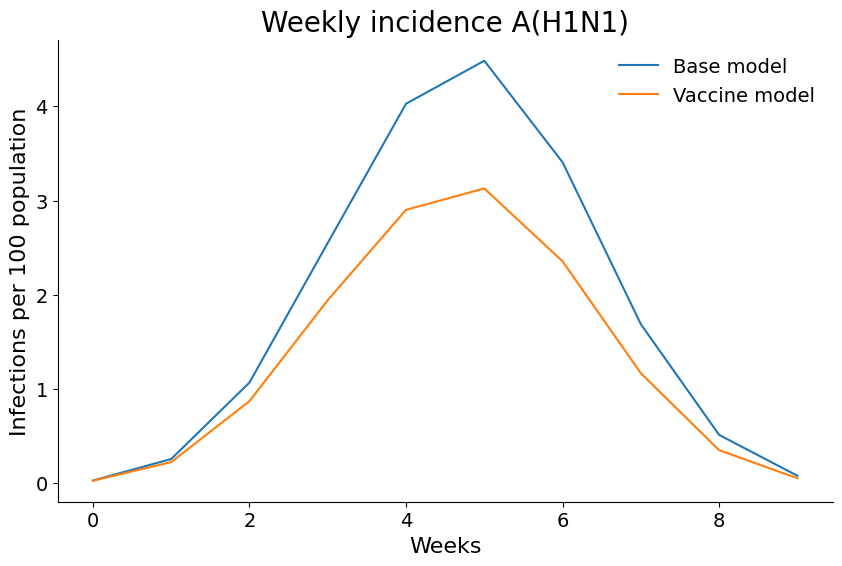

C:\Users\JackieL\AppData\Local\Temp\ipykernel_2116\3223270502.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(age_groups2, rotation=45, fontsize=16)


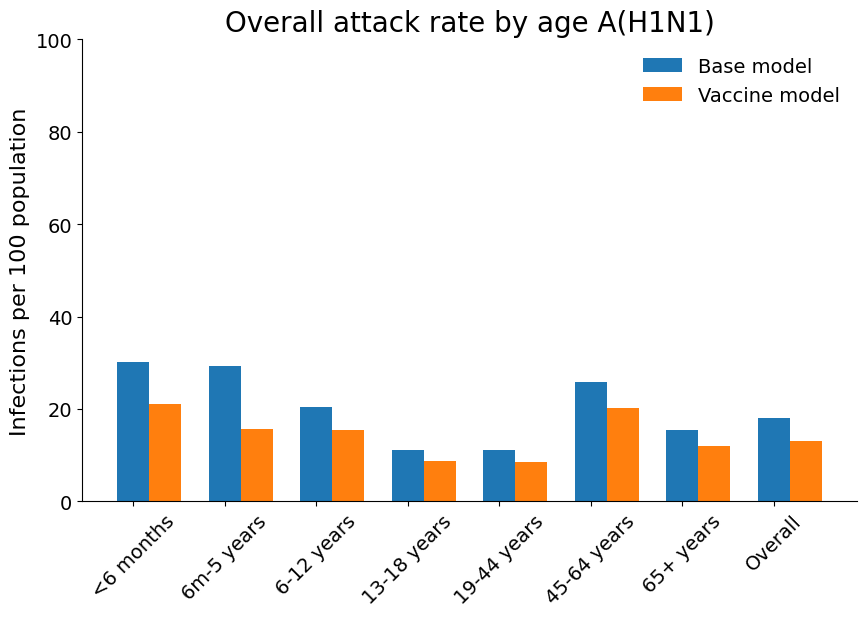

In [11]:
# Visualize a specific model

#Modesl to visualize
virus = 'A(H1N1)' #Options: ('A(H1N1)', 'A(H3N2)', 'B(Victoria)', 'B(Yamagata)')
base_model = man_check_unvac[virus]
vac_model = man_check_vac[virus]

#Visualize base model (no vaccination) and single vaccine model
plt.figure(figsize=(10, 6)) 
plt.plot(range(len(weekly_incidence(base_model))), weekly_incidence(base_model), label="Base model")
plt.plot(range(len(weekly_incidence(vac_model))), weekly_incidence(vac_model), label="Vaccine model")

ax = plt.gca()
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc='upper right', bbox_to_anchor=(1, 1), frameon=False, fontsize=14)
plt.title(f"Weekly incidence {virus}", fontsize=20)
plt.xlabel('Weeks', fontsize=16)
plt.ylabel('Infections per 100 population', fontsize=16)
plt.show()

age_groups2 = ["<6 months", "6m-5 years", "6-12 years", "13-18 years", "19-44 years", "45-64 years","65+ years", "Overall"]
bar_width = 0.35
index = np.arange(len(age_groups2))

# Visualize attack rates
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xticklabels(age_groups2, rotation=45, fontsize=16)
bar1 = ax.bar(index, ar_age_overall(base_model), bar_width, label='Base model')
bar2 = ax.bar(index + bar_width, ar_age_overall(vac_model), bar_width, label='Vaccine model')
ax.set_xticks(index)
ax.set_xticklabels(age_groups2, rotation=45, fontsize=16)
ax.set_ylabel('Infections per 100 population', fontsize=16)
ax.set_title(f'Overall attack rate by age {virus}', fontsize=20)
ax.legend(frameon=False, fontsize=14)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylim(0, 100)
plt.show()